# AI Writing Study Analysis: Re-reading and Revision Behavior

This notebook analyzes eye gaze data to understand user re-reading and revision behavior during essay writing across different writing modes (block, ai-only, manual).

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
sns.set_style('whitegrid')

## 1. Load and Parse Data

In [40]:
# Participant selection
PARTICIPANT_ID = 1
SESSION_ID = 1
WINDOW_MINUTES = 20

base_dir = f"data/{PARTICIPANT_ID:02d}"
gaze_path = f"{base_dir}/{PARTICIPANT_ID:02d}-{SESSION_ID}-gaze.json"
aoi_path = f"{base_dir}/{PARTICIPANT_ID:02d}-{SESSION_ID}-aoi.json"

print(f"Using participant {PARTICIPANT_ID}, session {SESSION_ID}")
print(f"Gaze file: {gaze_path}")
print(f"AOI file: {aoi_path}")
print(f"Window: last {WINDOW_MINUTES} minutes")

Using participant 1, session 1
Gaze file: data/01/01-1-gaze.json
AOI file: data/01/01-1-aoi.json
Window: last 20 minutes


In [42]:
# Load gaze data - each line is a JSON object
gaze_data = []
with open(gaze_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            gaze_data.append(json.loads(line))

gaze_df = pd.DataFrame(gaze_data)
print(f"Loaded {len(gaze_df)} gaze samples")
print(f"Time range: {gaze_df['timestamp'].min():.2f} to {gaze_df['timestamp'].max():.2f}")
print(f"Duration: {(gaze_df['timestamp'].max() - gaze_df['timestamp'].min()):.2f} seconds")
gaze_df.head()

Loaded 77621 gaze samples
Time range: 1770260958.48 to 1770262260.66
Duration: 1302.18 seconds


,timestamp,left_eye,right_eye
0,1.770261e+09,"[0.51473468542099, 0.06032887101173401]","[0.5267377495765686, 0.07877004891633987]"
1,1.770261e+09,"[0.5143505334854126, 0.056149695068597794]","[0.52498859167099, 0.07470296323299408]"
2,1.770261e+09,"[0.5180843472480774, 0.06082812324166298]","[0.5274941325187683, 0.08015119284391403]"
3,1.770261e+09,"[0.5522500276565552, 0.05537467822432518]","[0.559683620929718, 0.07754355669021606]"
4,1.770261e+09,"[0.5772774815559387, 0.056438568979501724]","[0.5906070470809937, 0.07532555609941483]"


In [43]:
# Load AOI data
with open(aoi_path, 'r') as f:
    aoi_data = json.load(f)

aoi_df = pd.DataFrame(aoi_data)
print(f"Loaded {len(aoi_df)} AOI logs")
print(f"\nLog types: {aoi_df['type'].value_counts().to_dict()}")

# Align to the end of the AOI log and keep only the last WINDOW_MINUTES
aoi_end_ms = aoi_df['ts'].max()
window_start_ms = aoi_end_ms - (WINDOW_MINUTES * 60 * 1000)

aoi_df = aoi_df[(aoi_df['ts'] >= window_start_ms) & (aoi_df['ts'] <= aoi_end_ms)].copy()
gaze_df = gaze_df[
    (gaze_df['timestamp'] >= window_start_ms / 1000)
    & (gaze_df['timestamp'] <= aoi_end_ms / 1000)
].copy()

print(f"\nFiltered to last {WINDOW_MINUTES} minutes")
print(f"AOI window (ms): {window_start_ms:.0f} to {aoi_end_ms:.0f}")
print(f"Filtered AOI logs: {len(aoi_df)}")
print(f"Filtered gaze samples: {len(gaze_df)}")
aoi_df.head()

Loaded 2887 AOI logs

Log types: {'AOI': 2815, 'TEXT_DIFF': 62, 'BLOCK_REORDER': 10}

Filtered to last 20 minutes
AOI window (ms): 1770261054749 to 1770262254749
Filtered AOI logs: 2757
Filtered gaze samples: 71627


,ts,sessionId,type,reason,writingMode,window,areas,location,by,addedWords,removedWords,targetId,blockId,indexId,editType,moveType,draggedBlockId,targetBlockId,oldParentId,newParentId
130,1770261055245,session-1770260877920,AOI,heartbeat,block,"{'innerWidth': 1900, 'innerHeight': 995, 'scro...","{'TopicInput': {'top': 149, 'left': 70, 'right...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
131,1770261055745,session-1770260877920,AOI,heartbeat,block,"{'innerWidth': 1900, 'innerHeight': 995, 'scro...","{'TopicInput': {'top': 149, 'left': 70, 'right...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132,1770261056245,session-1770260877920,AOI,heartbeat,block,"{'innerWidth': 1900, 'innerHeight': 995, 'scro...","{'TopicInput': {'top': 149, 'left': 70, 'right...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133,1770261056744,session-1770260877920,AOI,heartbeat,block,"{'innerWidth': 1900, 'innerHeight': 995, 'scro...","{'TopicInput': {'top': 149, 'left': 70, 'right...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,1770261057245,session-1770260877920,AOI,heartbeat,block,"{'innerWidth': 1900, 'innerHeight': 995, 'scro...","{'TopicInput': {'top': 149, 'left': 70, 'right...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Process Gaze Data

Convert normalized coordinates (0-1) to pixel coordinates and handle NaN values.

In [44]:
# Extract left and right eye coordinates
gaze_df['left_x'] = gaze_df['left_eye'].apply(lambda x: x[0] if isinstance(x, list) else np.nan)
gaze_df['left_y'] = gaze_df['left_eye'].apply(lambda x: x[1] if isinstance(x, list) else np.nan)
gaze_df['right_x'] = gaze_df['right_eye'].apply(lambda x: x[0] if isinstance(x, list) else np.nan)
gaze_df['right_y'] = gaze_df['right_eye'].apply(lambda x: x[1] if isinstance(x, list) else np.nan)

# Calculate average gaze position (when both eyes are tracked, use average; otherwise use available eye)
gaze_df['gaze_x'] = gaze_df[['left_x', 'right_x']].mean(axis=1)
gaze_df['gaze_y'] = gaze_df[['left_y', 'right_y']].mean(axis=1)

# Mark valid gaze samples (within screen bounds 0-1)
gaze_df['valid_gaze'] = (
    (gaze_df['gaze_x'] >= 0) & (gaze_df['gaze_x'] <= 1) &
    (gaze_df['gaze_y'] >= 0) & (gaze_df['gaze_y'] <= 1) &
    gaze_df['gaze_x'].notna() & gaze_df['gaze_y'].notna()
)

print(f"Valid gaze samples: {gaze_df['valid_gaze'].sum()} / {len(gaze_df)} ({gaze_df['valid_gaze'].mean()*100:.1f}%)")
gaze_df[['timestamp', 'gaze_x', 'gaze_y', 'valid_gaze']].head(10)

Valid gaze samples: 45683 / 71627 (63.8%)


,timestamp,gaze_x,gaze_y,valid_gaze
5658,1.770261e+09,0.188190,0.242419,True
5659,1.770261e+09,0.193209,0.243695,True
5660,1.770261e+09,0.191944,0.247143,True
5661,1.770261e+09,0.191451,0.248407,True
5662,1.770261e+09,0.191600,0.246603,True
5663,1.770261e+09,0.192492,0.245452,True
5664,1.770261e+09,0.194333,0.249387,True
5665,1.770261e+09,0.195262,0.251586,True
5666,1.770261e+09,0.192996,0.248037,True
5667,1.770261e+09,0.192115,0.250505,True


## 3. Extract AOI Positions

Extract Area of Interest boundaries for each writing mode over time.

In [45]:
# Filter AOI logs only
aoi_logs = aoi_df[aoi_df['type'] == 'AOI'].copy()
print(f"AOI logs: {len(aoi_logs)}")

# Examine writing modes
print(f"\nWriting modes: {aoi_logs['writingMode'].value_counts().to_dict()}")

# Look at one example to understand the structure
print("\nExample AOI log:")
print(json.dumps(aoi_logs.iloc[0].to_dict(), indent=2))

AOI logs: 2688

Writing modes: {'block': 2688}

Example AOI log:
{
  "ts": 1770261055245,
  "sessionId": "session-1770260877920",
  "type": "AOI",
  "reason": "heartbeat",
  "writingMode": "block",
  "window": {
    "innerWidth": 1900,
    "innerHeight": 995,
    "scrollX": 0,
    "scrollY": 0,
    "dpr": 1
  },
  "areas": {
    "TopicInput": {
      "top": 149,
      "left": 70,
      "right": 1830,
      "bottom": 322
    },
    "WritingBlock": {
      "top": 343,
      "left": 70,
      "right": 1830,
      "bottom": 343
    },
    "TextEditor": {
      "top": 381.5,
      "left": 70,
      "right": 936,
      "bottom": 783.5
    },
    "DevelopedTextPanel": {
      "top": 381.5,
      "left": 964,
      "right": 1830,
      "bottom": 783.5
    }
  },
  "location": NaN,
  "by": NaN,
  "addedWords": NaN,
  "removedWords": NaN,
  "targetId": NaN,
  "blockId": NaN,
  "indexId": NaN,
  "editType": NaN,
  "moveType": NaN,
  "draggedBlockId": NaN,
  "targetBlockId": NaN,
  "oldParentId": 

In [46]:
# Extract AOI rectangles for each component
def extract_aoi_rectangles(aoi_log):
    """Extract AOI rectangles from a log entry"""
    rectangles = {}
    window_width = aoi_log['window']['innerWidth']
    window_height = aoi_log['window']['innerHeight']
    
    # Extract each component's position from 'areas' dictionary
    if 'areas' in aoi_log and isinstance(aoi_log['areas'], dict):
        for component_name, bounds in aoi_log['areas'].items():
            if isinstance(bounds, dict) and 'left' in bounds and 'top' in bounds:
                # Normalize coordinates to 0-1 range for comparison with gaze data
                rectangles[component_name] = {
                    'x_min': bounds['left'] / window_width,
                    'y_min': bounds['top'] / window_height,
                    'x_max': bounds['right'] / window_width,
                    'y_max': bounds['bottom'] / window_height,
                }
    
    return rectangles, window_width, window_height

# Process all AOI logs
aoi_logs['rectangles'] = aoi_logs.apply(extract_aoi_rectangles, axis=1)
aoi_logs['aoi_rects'] = aoi_logs['rectangles'].apply(lambda x: x[0])
aoi_logs['screen_width'] = aoi_logs['rectangles'].apply(lambda x: x[1])
aoi_logs['screen_height'] = aoi_logs['rectangles'].apply(lambda x: x[2])

# Display available components for each mode
print("Available AOI components by writing mode:")
for mode in aoi_logs['writingMode'].unique():
    mode_logs = aoi_logs[aoi_logs['writingMode'] == mode]
    if len(mode_logs) > 0:
        components = list(mode_logs.iloc[0]['aoi_rects'].keys())
        print(f"  {mode}: {components}")


Available AOI components by writing mode:
  block: ['TopicInput', 'WritingBlock', 'TextEditor', 'DevelopedTextPanel']


## 4. Map Gaze to AOIs

For each gaze sample, determine which AOI it falls into based on the current writing mode and AOI configuration.

In [47]:
def point_in_rect(x, y, rect):
    """Check if point (x, y) is inside rectangle"""
    return (rect['x_min'] <= x <= rect['x_max'] and 
            rect['y_min'] <= y <= rect['y_max'])

def find_aoi_at_timestamp(timestamp, gaze_x, gaze_y, aoi_logs):
    """Find which AOI the gaze falls into at a given timestamp"""
    if pd.isna(gaze_x) or pd.isna(gaze_y):
        return None, None
    
    # Convert timestamp to milliseconds to match AOI log format (ts is in ms)
    timestamp_ms = timestamp * 1000
    
    # Find the most recent AOI log before or at this timestamp
    valid_aoi_logs = aoi_logs[aoi_logs['ts'] <= timestamp_ms]
    if len(valid_aoi_logs) == 0:
        return None, None
    
    current_aoi = valid_aoi_logs.iloc[-1]
    writing_mode = current_aoi['writingMode']
    rectangles = current_aoi['aoi_rects']
    
    # Check which component the gaze falls into
    for component_name, rect in rectangles.items():
        if point_in_rect(gaze_x, gaze_y, rect):
            return writing_mode, component_name
    
    return writing_mode, 'outside_aoi'

# Map each gaze sample to an AOI
print("Mapping gaze samples to AOIs...")
gaze_results = gaze_df[gaze_df['valid_gaze']].apply(
    lambda row: find_aoi_at_timestamp(row['timestamp'], row['gaze_x'], row['gaze_y'], aoi_logs),
    axis=1
)

gaze_df.loc[gaze_df['valid_gaze'], 'writing_mode'] = gaze_results.apply(lambda x: x[0])
gaze_df.loc[gaze_df['valid_gaze'], 'aoi_component'] = gaze_results.apply(lambda x: x[1])

print("Done!")
gaze_df[['timestamp', 'gaze_x', 'gaze_y', 'writing_mode', 'aoi_component']].head(20)

Mapping gaze samples to AOIs...
Done!


,timestamp,gaze_x,gaze_y,writing_mode,aoi_component
5658,1.770261e+09,0.188190,0.242419,NaN,NaN
5659,1.770261e+09,0.193209,0.243695,NaN,NaN
5660,1.770261e+09,0.191944,0.247143,NaN,NaN
5661,1.770261e+09,0.191451,0.248407,NaN,NaN
5662,1.770261e+09,0.191600,0.246603,NaN,NaN
5663,1.770261e+09,0.192492,0.245452,NaN,NaN
5664,1.770261e+09,0.194333,0.249387,NaN,NaN
5665,1.770261e+09,0.195262,0.251586,NaN,NaN
5666,1.770261e+09,0.192996,0.248037,NaN,NaN
5667,1.770261e+09,0.192115,0.250505,NaN,NaN


## 5. Calculate Gaze Time in Each Area by Writing Mode

Calculate how many seconds the user's gaze was in each AOI component for each writing mode.

In [48]:
# Filter valid gaze samples with AOI mapping
valid_gaze = gaze_df[gaze_df['writing_mode'].notna()].copy()

# Calculate time between samples (assuming 60Hz, ~16.67ms per sample)
# We'll use actual time differences for accuracy
valid_gaze['time_diff'] = valid_gaze['timestamp'].diff()

# Remove outliers (gaps > 1 second indicate data loss or mode transition)
valid_gaze.loc[valid_gaze['time_diff'] > 1, 'time_diff'] = np.nan

# For first sample in each mode, estimate from frequency
avg_sample_time = 1/60  # 60Hz
valid_gaze['time_diff'] = valid_gaze['time_diff'].fillna(avg_sample_time)

print(f"Average time per sample: {valid_gaze['time_diff'].mean()*1000:.2f} ms")
print(f"Expected at 60Hz: {1000/60:.2f} ms")

Average time per sample: 18.45 ms
Expected at 60Hz: 16.67 ms


In [49]:
# Calculate total time in each AOI by writing mode
gaze_time_summary = valid_gaze.groupby(['writing_mode', 'aoi_component'])['time_diff'].sum().reset_index()
gaze_time_summary.columns = ['writing_mode', 'aoi_component', 'total_seconds']
gaze_time_summary = gaze_time_summary.sort_values(['writing_mode', 'total_seconds'], ascending=[True, False])

print("\n=== Gaze Time by Writing Mode and AOI Component ===")
print(gaze_time_summary.to_string(index=False))

# Calculate percentages within each writing mode
mode_totals = gaze_time_summary.groupby('writing_mode')['total_seconds'].sum()
gaze_time_summary['percentage'] = gaze_time_summary.apply(
    lambda row: (row['total_seconds'] / mode_totals[row['writing_mode']]) * 100,
    axis=1
)

print("\n=== Gaze Time with Percentages ===")
print(gaze_time_summary.to_string(index=False))


=== Gaze Time by Writing Mode and AOI Component ===
writing_mode      aoi_component  total_seconds
       block         TextEditor     500.499937
       block DevelopedTextPanel     233.169020
       block       WritingBlock      41.017694
       block         TopicInput      40.677574
       block        outside_aoi      27.009902

=== Gaze Time with Percentages ===
writing_mode      aoi_component  total_seconds  percentage
       block         TextEditor     500.499937   59.415398
       block DevelopedTextPanel     233.169020   27.679984
       block       WritingBlock      41.017694    4.869297
       block         TopicInput      40.677574    4.828920
       block        outside_aoi      27.009902    3.206402


## 6. Visualize Gaze Distribution

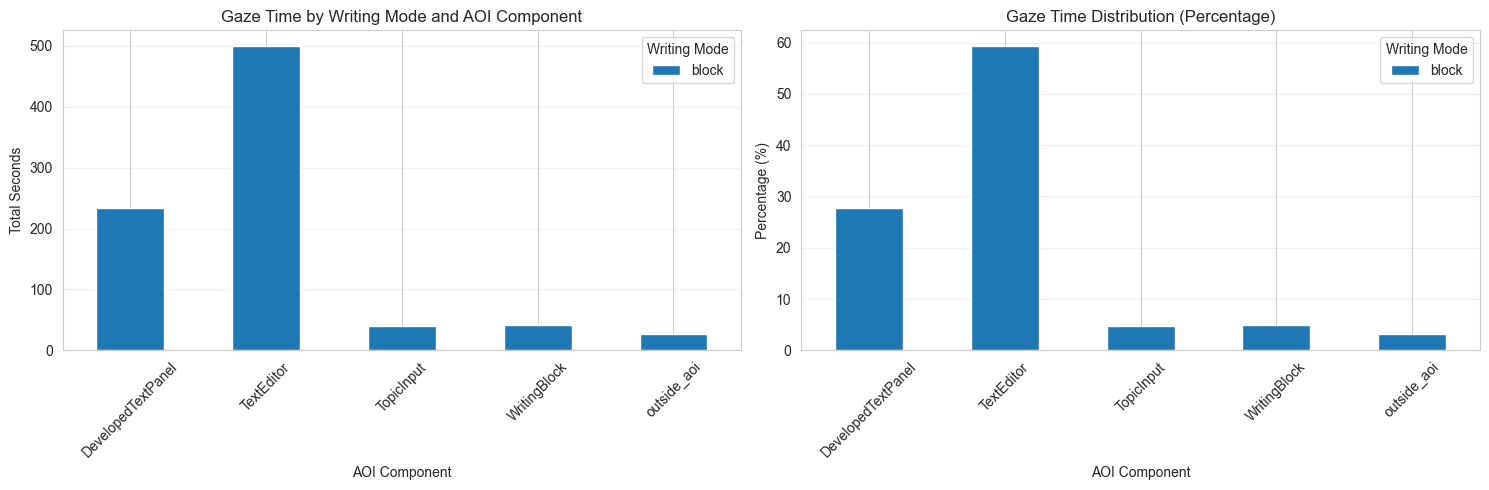

In [50]:
# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Total seconds by mode and component
pivot_seconds = gaze_time_summary.pivot(index='aoi_component', columns='writing_mode', values='total_seconds').fillna(0)
pivot_seconds.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Gaze Time by Writing Mode and AOI Component')
axes[0].set_xlabel('AOI Component')
axes[0].set_ylabel('Total Seconds')
axes[0].legend(title='Writing Mode')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Percentage distribution
pivot_pct = gaze_time_summary.pivot(index='aoi_component', columns='writing_mode', values='percentage').fillna(0)
pivot_pct.plot(kind='bar', ax=axes[1], rot=45)
axes[1].set_title('Gaze Time Distribution (Percentage)')
axes[1].set_xlabel('AOI Component')
axes[1].set_ylabel('Percentage (%)')
axes[1].legend(title='Writing Mode')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Summary Statistics by Writing Mode

In [51]:
# Calculate total time in each writing mode
mode_summary = valid_gaze.groupby('writing_mode').agg({
    'time_diff': 'sum',
    'timestamp': 'count'
}).reset_index()
mode_summary.columns = ['writing_mode', 'total_seconds', 'sample_count']

print("\n=== Total Time in Each Writing Mode ===")
print(mode_summary.to_string(index=False))

# Key components for re-reading analysis
print("\n=== Re-reading Behavior Indicators ===")
for mode in gaze_time_summary['writing_mode'].unique():
    if pd.notna(mode):
        print(f"\n{mode.upper()} mode:")
        mode_data = gaze_time_summary[gaze_time_summary['writing_mode'] == mode]
        for _, row in mode_data.iterrows():
            print(f"  {row['aoi_component']}: {row['total_seconds']:.2f}s ({row['percentage']:.1f}%)")


=== Total Time in Each Writing Mode ===
writing_mode  total_seconds  sample_count
       block     842.374127         45663

=== Re-reading Behavior Indicators ===

BLOCK mode:
  TextEditor: 500.50s (59.4%)
  DevelopedTextPanel: 233.17s (27.7%)
  WritingBlock: 41.02s (4.9%)
  TopicInput: 40.68s (4.8%)
  outside_aoi: 27.01s (3.2%)


## Next Steps

This initial analysis shows the distribution of gaze time across different AOI components for each writing mode. 

**Future analyses to explore:**
1. **Fixation Detection**: ~~Use pymovements library to detect fixations and calculate fixation duration in each AOI~~ DONE ✅
2. **Revision Analysis**: ~~Analyze TEXT_DIFF logs to count words added/removed in each mode and location~~ DONE ✅
3. **Block Reordering**: Analyze BLOCK_REORDER logs to understand revision patterns in block mode
4. **Temporal Patterns**: ~~Analyze fixation patterns over time to identify how attention flowed~~ DONE ✅
5. **Cross-mode Comparison**: Compare re-reading behavior between block vs ai-only vs manual modes

## 8. Fixation Detection with pymovements

Now we'll use the pymovements library to detect fixations from the raw gaze data. Fixations represent periods when the eyes are relatively stationary and focused on a specific location, which is more meaningful for understanding re-reading behavior than raw gaze position.

In [52]:
# Import pymovements
import pymovements as pm

print(f"pymovements version: {pm.__version__}")
print("pymovements successfully loaded!")

pymovements version: 0+untagged.26.ga45cad9.dirty
pymovements successfully loaded!


In [53]:
# Prepare gaze data for pymovements
# pymovements expects columns: time, x_left, y_left, x_right, y_right (or pixel/position columns)
# We'll use normalized coordinates (0-1 range)

pm_gaze_df = pd.DataFrame({
    'time': gaze_df['timestamp'],
    'x_left': gaze_df['left_x'],
    'y_left': gaze_df['left_y'],
    'x_right': gaze_df['right_x'],
    'y_right': gaze_df['right_y'],
})

# Calculate average position for monocular processing
pm_gaze_df['x'] = pm_gaze_df[['x_left', 'x_right']].mean(axis=1)
pm_gaze_df['y'] = pm_gaze_df[['y_left', 'y_right']].mean(axis=1)

print(f"Prepared {len(pm_gaze_df)} gaze samples for fixation detection")
print(f"Time range: {pm_gaze_df['time'].min():.2f} to {pm_gaze_df['time'].max():.2f} seconds")
pm_gaze_df.head()

Prepared 71627 gaze samples for fixation detection
Time range: 1770261054.76 to 1770262254.75 seconds


,time,x_left,y_left,x_right,y_right,x,y
5658,1.770261e+09,0.187559,0.243483,0.188821,0.241356,0.188190,0.242419
5659,1.770261e+09,0.191184,0.247020,0.195233,0.240369,0.193209,0.243695
5660,1.770261e+09,0.188749,0.251587,0.195138,0.242699,0.191944,0.247143
5661,1.770261e+09,0.189928,0.252265,0.192974,0.244550,0.191451,0.248407
5662,1.770261e+09,0.192146,0.249561,0.191054,0.243646,0.191600,0.246603


In [54]:
# Create a pymovements Gaze object
# pymovements expects PIXEL coordinates, not normalized 0-1 coordinates

import polars as pl

# Screen dimensions (from AOI logs)
screen_width_px = 1900
screen_height_px = 995

# Convert normalized (0-1) coordinates to pixel coordinates
gaze_data_for_pm = pm_gaze_df[['time', 'x', 'y']].dropna().reset_index(drop=True)
gaze_data_for_pm['x_px'] = gaze_data_for_pm['x'] * screen_width_px
gaze_data_for_pm['y_px'] = gaze_data_for_pm['y'] * screen_height_px

# Create polars DataFrame with pixel coordinates
gaze_data_pl = pl.from_pandas(gaze_data_for_pm[['time', 'x_px', 'y_px']])
gaze_data_pl = gaze_data_pl.rename({
    'time': 't',
    'x_px': 'x_pix', 
    'y_px': 'y_pix'
})

# Create Gaze object with pixel coordinates
gaze_dataframe = pm.gaze.Gaze(
    gaze_data_pl,
    pixel_columns=['x_pix', 'y_pix'],
    time_column='t',
)

# Set up experiment metadata
experiment = pm.gaze.experiment.Experiment(
    screen_width_px=screen_width_px,
    screen_height_px=screen_height_px,
    screen_width_cm=50,  # Estimated screen width in cm
    screen_height_cm=26,  # Estimated screen height in cm
    distance_cm=60,  # Estimated viewing distance in cm
    sampling_rate=60,  # 60 Hz sampling rate
)
gaze_dataframe.experiment = experiment

print(f"Created Gaze object with {gaze_dataframe.samples.shape[0]} samples")
print(f"Screen: {screen_width_px}x{screen_height_px} pixels")
print(f"Pixel coordinate ranges:")
print(f"  X: {gaze_data_for_pm['x_px'].min():.1f} to {gaze_data_for_pm['x_px'].max():.1f}")
print(f"  Y: {gaze_data_for_pm['y_px'].min():.1f} to {gaze_data_for_pm['y_px'].max():.1f}")
print(gaze_dataframe.samples.head())


Created Gaze object with 60203 samples
Screen: 1900x995 pixels
Pixel coordinate ranges:
  X: -378.1 to 2274.2
  Y: -198.2 to 2188.0
shape: (5, 2)
┌──────────┬──────────────────────────┐
│ time     ┆ pixel                    │
│ ---      ┆ ---                      │
│ f64      ┆ list[f64]                │
╞══════════╪══════════════════════════╡
│ 1.7703e9 ┆ [357.561393, 241.207362] │
│ 1.7703e9 ┆ [367.096534, 242.476353] │
│ 1.7703e9 ┆ [364.692983, 245.90756]  │
│ 1.7703e9 ┆ [363.756727, 247.165431] │
│ 1.7703e9 ┆ [364.040429, 245.370301] │
└──────────┴──────────────────────────┘


In [55]:
# Detect fixations using I-VT algorithm - following pymovements documentation
# Simple 3-step process: pix2deg → pos2vel → detect

print("=== Fixation Detection with pymovements ===")
print("Following the simple workflow from pymovements documentation:\n")

# Step 1: Transform pixel coordinates to degrees of visual angle
print("Step 1: pix2deg() - Convert pixels to degrees of visual angle")
gaze_dataframe.pix2deg()
print("  ✓ Conversion complete")

# Step 2: Transform positional data to velocity data
print("Step 2: pos2vel() - Calculate velocity from position")
gaze_dataframe.pos2vel()
print("  ✓ Velocity calculated")

# Check velocity values
samples_pd = gaze_dataframe.samples.to_pandas()
vel_magnitudes = samples_pd['velocity'].apply(
    lambda v: np.sqrt(v[0]**2 + v[1]**2) if isinstance(v, (list, tuple, np.ndarray)) and len(v) >= 2 else np.nan
)
print(f"\nVelocity statistics:")
print(f"  Range: {vel_magnitudes.min():.2f} to {vel_magnitudes.max():.2f} deg/s")
print(f"  Median: {vel_magnitudes.median():.2f} deg/s")
print(f"  Mean: {vel_magnitudes.mean():.2f} deg/s")

# Step 3: Detect fixations using I-VT algorithm
# IMPORTANT: minimum_duration parameter is REQUIRED for pymovements I-VT
# Standard parameters for reading tasks:
#   - velocity_threshold: 20-30 deg/s (eye velocity below this = fixation)
#   - minimum_duration: 0.05-0.1 seconds (50-100ms)
print("\nStep 3: detect('ivt') - Detect fixations")
print("  Using standard parameters for reading/writing:")
print("    velocity_threshold = 30 deg/s")
print("    minimum_duration = 0.1 seconds (100ms)")

gaze_dataframe.detect('ivt', velocity_threshold=30, minimum_duration=0.1)
fixations = gaze_dataframe.events.fixations

print(f"\n=== RESULTS ===")
print(f"✓ Detected {len(fixations)} fixations")
print(f"Recording duration: {(gaze_df['timestamp'].max() - gaze_df['timestamp'].min()):.1f}s ({(gaze_df['timestamp'].max() - gaze_df['timestamp'].min())/60:.1f} minutes)")
print(f"Fixations per minute: {len(fixations) / ((gaze_df['timestamp'].max() - gaze_df['timestamp'].min()) / 60):.1f}")

if len(fixations) > 0:
    fix_df = fixations.to_pandas()
    print(f"\nFixation duration statistics:")
    print(f"  Min: {fix_df['duration'].min():.1f} ms")
    print(f"  Max: {fix_df['duration'].max():.1f} ms")
    print(f"  Mean: {fix_df['duration'].mean():.1f} ms")
    print(f"  Median: {fix_df['duration'].median():.1f} ms")
    
    print(f"\nFirst 20 fixations:")
    print(fixations.head(20))


=== Fixation Detection with pymovements ===
Following the simple workflow from pymovements documentation:

Step 1: pix2deg() - Convert pixels to degrees of visual angle
  ✓ Conversion complete
Step 2: pos2vel() - Calculate velocity from position
  ✓ Velocity calculated

Velocity statistics:
  Range: 0.02 to 1059.91 deg/s
  Median: 6.72 deg/s
  Mean: 32.40 deg/s

Step 3: detect('ivt') - Detect fixations
  Using standard parameters for reading/writing:
    velocity_threshold = 30 deg/s
    minimum_duration = 0.1 seconds (100ms)

=== RESULTS ===
✓ Detected 1878 fixations
Recording duration: 1200.0s (20.0 minutes)
Fixations per minute: 93.9

Fixation duration statistics:
  Min: 0.1 ms
  Max: 5.6 ms
  Mean: 0.4 ms
  Median: 0.3 ms

First 20 fixations:
shape: (20, 4)
┌──────────┬──────────┬──────────┬──────────┐
│ name     ┆ onset    ┆ offset   ┆ duration │
│ ---      ┆ ---      ┆ ---      ┆ ---      │
│ str      ┆ f64      ┆ f64      ┆ f64      │
╞══════════╪══════════╪══════════╪══════════

## 9. Map Fixations to AOI Components

Now we'll map each fixation to the corresponding AOI component based on its position and timestamp.

In [56]:
# Convert fixations from polars to pandas for easier processing
fixations_df = fixations.to_pandas()

print(f"Processing {len(fixations_df)} fixations...")
print(f"\nFixation data columns: {fixations_df.columns.tolist()}")
print(f"\nFirst few fixations:")
print(fixations_df.head(10))


Processing 1878 fixations...

Fixation data columns: ['name', 'onset', 'offset', 'duration']

First few fixations:
       name         onset        offset  duration
0  fixation  1.770261e+09  1.770261e+09  0.199255
1  fixation  1.770261e+09  1.770261e+09  0.149875
2  fixation  1.770261e+09  1.770261e+09  0.132678
3  fixation  1.770261e+09  1.770261e+09  0.168378
4  fixation  1.770261e+09  1.770261e+09  0.415767
5  fixation  1.770261e+09  1.770261e+09  0.182975
6  fixation  1.770261e+09  1.770261e+09  0.465937
7  fixation  1.770261e+09  1.770261e+09  0.266220
8  fixation  1.770261e+09  1.770261e+09  0.366450
9  fixation  1.770261e+09  1.770261e+09  0.648854


In [57]:
# Map each fixation to an AOI component
def map_fixation_to_aoi(fixation_row, gaze_samples, aoi_logs):
    """Map a fixation to the corresponding AOI component"""
    try:
        # Get fixation time (onset is in seconds)
        fix_time = fixation_row['onset']
        
        # Find all gaze samples during this fixation period
        offset_time = fixation_row['offset']
        gaze_during_fix = gaze_samples[
            gaze_samples['timestamp'].between(fix_time, offset_time)
        ]
        
        if len(gaze_during_fix) == 0:
            return None, None, 0
        
        # Use the mean gaze position during the fixation
        fix_x = gaze_during_fix['gaze_x'].mean()
        fix_y = gaze_during_fix['gaze_y'].mean()
        
        if pd.isna(fix_x) or pd.isna(fix_y):
            return None, None, 0
        
        # Map to AOI using the fixation start time
        writing_mode, component = find_aoi_at_timestamp(fix_time, fix_x, fix_y, aoi_logs)
        
        # Duration from pymovements is already in seconds
        duration = fixation_row['duration']
        
        return writing_mode, component, duration
        
    except Exception as e:
        print(f"Error mapping fixation: {e}")
        return None, None, 0

print("Mapping fixations to AOI components...")
print(f"Total fixations to map: {len(fixations_df)}")

fixation_mapping = []
for idx, row in fixations_df.iterrows():
    result = map_fixation_to_aoi(row, gaze_df, aoi_logs)
    fixation_mapping.append(result)

fixation_mapping_df = pd.DataFrame(
    fixation_mapping,
    columns=['writing_mode', 'aoi_component', 'duration']
)

fixations_df['writing_mode'] = fixation_mapping_df['writing_mode']
fixations_df['aoi_component'] = fixation_mapping_df['aoi_component']
fixations_df['fixation_duration'] = fixation_mapping_df['duration']

# Filter out fixations without AOI mapping
fixations_with_aoi = fixations_df[fixations_df['writing_mode'].notna()].copy()

print(f"\nMapped {len(fixations_with_aoi)} / {len(fixations_df)} fixations to AOI components")
print(f"Unmapped fixations: {len(fixations_df) - len(fixations_with_aoi)}")

if len(fixations_with_aoi) > 0:
    print(f"\n=== Fixations by Writing Mode ===")
    print(fixations_with_aoi['writing_mode'].value_counts())
    print(f"\n=== Fixations by AOI Component ===")
    print(fixations_with_aoi['aoi_component'].value_counts())
    print("\n=== Sample Fixation Durations (should be in seconds) ===")
    print(fixations_with_aoi[['onset', 'offset', 'duration', 'writing_mode', 'aoi_component', 'fixation_duration']].head(20))
    print(f"\n=== Fixation Duration Statistics ===")
    print(f"Min: {fixations_with_aoi['fixation_duration'].min():.3f}s")
    print(f"Max: {fixations_with_aoi['fixation_duration'].max():.3f}s")
    print(f"Mean: {fixations_with_aoi['fixation_duration'].mean():.3f}s")
    print(f"Median: {fixations_with_aoi['fixation_duration'].median():.3f}s")
    print(f"Total: {fixations_with_aoi['fixation_duration'].sum():.3f}s")
else:
    print("\n⚠️ No fixations mapped to AOI components - they may all be outside recorded AOI boundaries")


Mapping fixations to AOI components...
Total fixations to map: 1878

Mapped 1876 / 1878 fixations to AOI components
Unmapped fixations: 2

=== Fixations by Writing Mode ===
writing_mode
block    1876
Name: count, dtype: int64

=== Fixations by AOI Component ===
aoi_component
TextEditor            768
outside_aoi           648
DevelopedTextPanel    318
WritingBlock           88
TopicInput             54
Name: count, dtype: int64

=== Sample Fixation Durations (should be in seconds) ===
           onset        offset  duration writing_mode aoi_component  \
2   1.770261e+09  1.770261e+09  0.132678        block   outside_aoi   
3   1.770261e+09  1.770261e+09  0.168378        block   outside_aoi   
4   1.770261e+09  1.770261e+09  0.415767        block   outside_aoi   
5   1.770261e+09  1.770261e+09  0.182975        block   outside_aoi   
6   1.770261e+09  1.770261e+09  0.465937        block    TopicInput   
7   1.770261e+09  1.770261e+09  0.266220        block    TopicInput   
8   1.770261e

## 10. Calculate Fixation Time by AOI Component

Calculate the total fixation duration for each AOI component in each writing mode.

In [58]:
# Calculate total fixation time by writing mode and AOI component
if len(fixations_with_aoi) > 0:
    fixation_time_summary = fixations_with_aoi.groupby(['writing_mode', 'aoi_component']).agg({
        'fixation_duration': ['sum', 'count', 'mean']
    }).reset_index()
    
    fixation_time_summary.columns = ['writing_mode', 'aoi_component', 'total_fixation_time', 'fixation_count', 'avg_fixation_duration']
    fixation_time_summary = fixation_time_summary.sort_values(['writing_mode', 'total_fixation_time'], ascending=[True, False])
    
    print("=== Fixation Time by Writing Mode and AOI Component ===")
    print(fixation_time_summary.to_string(index=False))
    
    # Calculate percentages within each writing mode
    mode_totals_fix = fixation_time_summary.groupby('writing_mode')['total_fixation_time'].sum()
    fixation_time_summary['percentage'] = fixation_time_summary.apply(
        lambda row: (row['total_fixation_time'] / mode_totals_fix[row['writing_mode']]) * 100
        if row['writing_mode'] in mode_totals_fix.index else 0,
        axis=1
    )
    
    print("\n=== Fixation Time with Percentages ===")
    print(fixation_time_summary.to_string(index=False))
else:
    print("No fixations mapped to AOI components. Fixation time summary is empty.")
    fixation_time_summary = pd.DataFrame(columns=['writing_mode', 'aoi_component', 'total_fixation_time', 'fixation_count', 'avg_fixation_duration', 'percentage'])


=== Fixation Time by Writing Mode and AOI Component ===
writing_mode      aoi_component  total_fixation_time  fixation_count  avg_fixation_duration
       block         TextEditor           380.437294             768               0.495361
       block DevelopedTextPanel           197.361310             318               0.620633
       block        outside_aoi           132.170553             648               0.203967
       block         TopicInput            32.136517              54               0.595121
       block       WritingBlock            31.339639              88               0.356132

=== Fixation Time with Percentages ===
writing_mode      aoi_component  total_fixation_time  fixation_count  avg_fixation_duration  percentage
       block         TextEditor           380.437294             768               0.495361   49.187355
       block DevelopedTextPanel           197.361310             318               0.620633   25.517164
       block        outside_aoi         

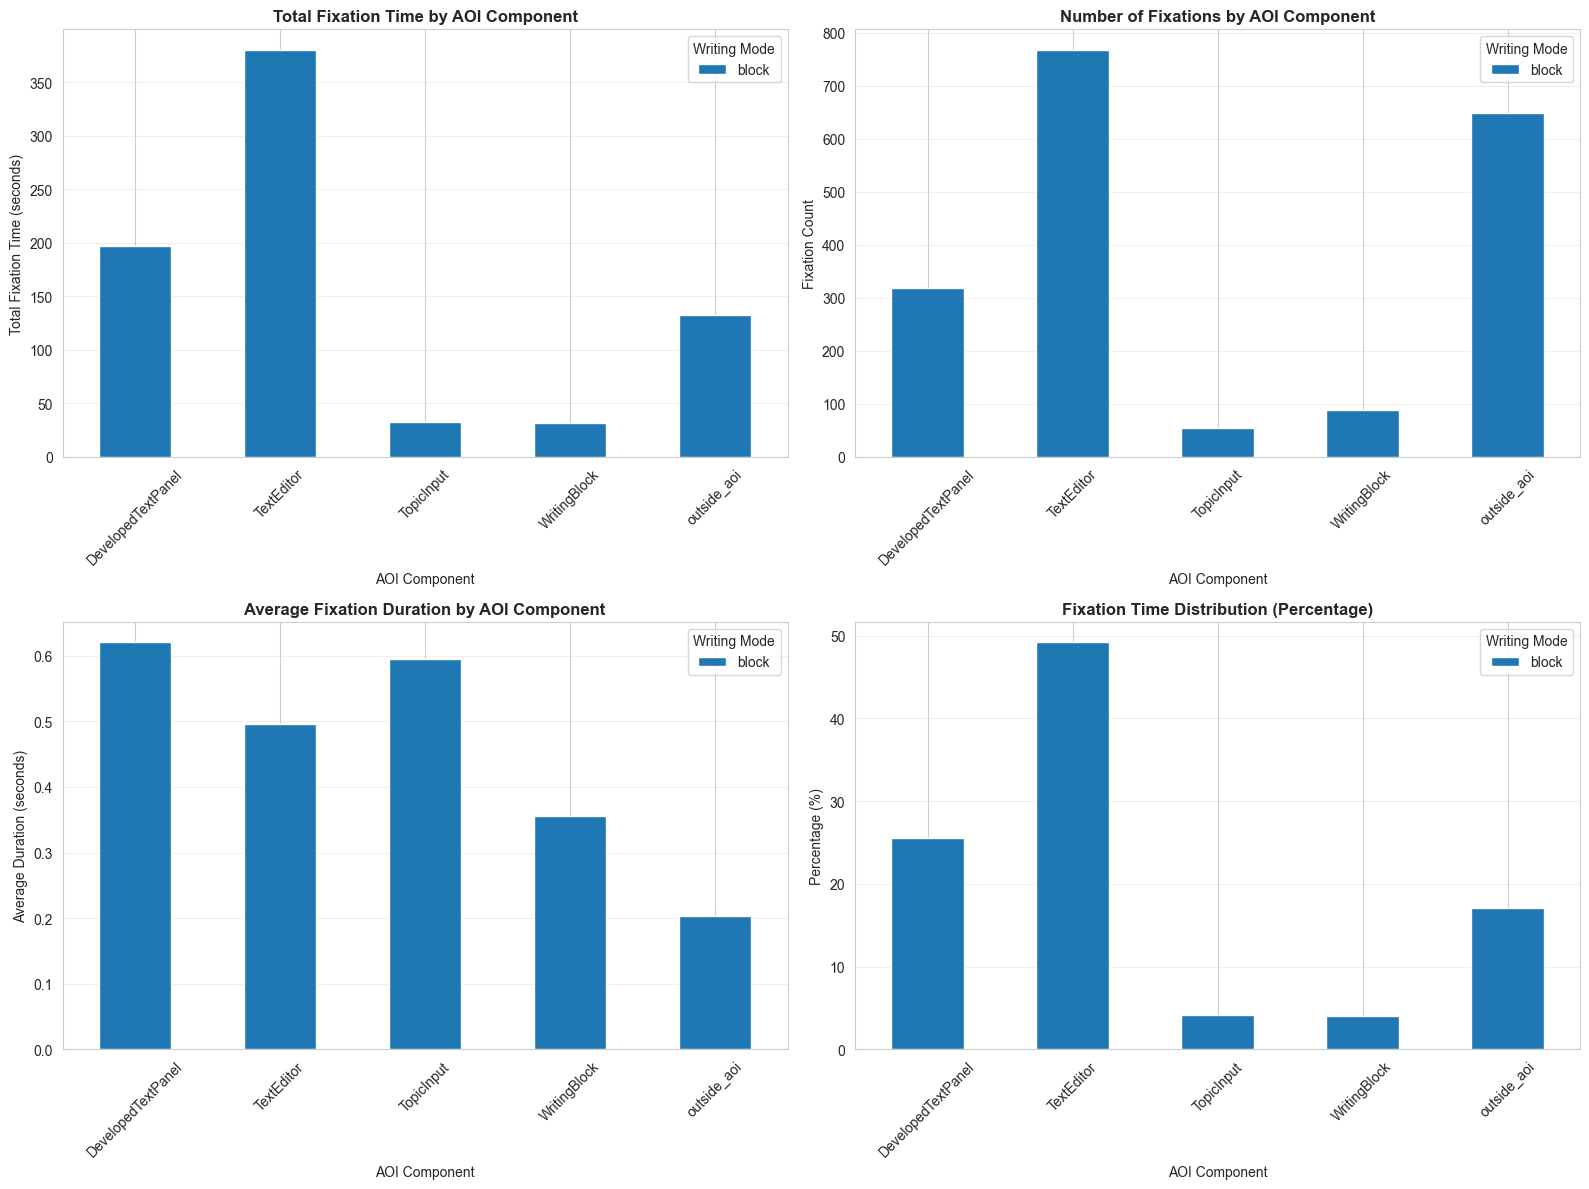

In [59]:
# Visualize fixation time distribution
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total fixation time by component
pivot_fix_time = fixation_time_summary.pivot(
    index='aoi_component', 
    columns='writing_mode', 
    values='total_fixation_time'
).fillna(0)
pivot_fix_time.plot(kind='bar', ax=axes[0, 0], rot=45)
axes[0, 0].set_title('Total Fixation Time by AOI Component', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('AOI Component')
axes[0, 0].set_ylabel('Total Fixation Time (seconds)')
axes[0, 0].legend(title='Writing Mode')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Fixation count by component
pivot_fix_count = fixation_time_summary.pivot(
    index='aoi_component', 
    columns='writing_mode', 
    values='fixation_count'
).fillna(0)
pivot_fix_count.plot(kind='bar', ax=axes[0, 1], rot=45)
axes[0, 1].set_title('Number of Fixations by AOI Component', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('AOI Component')
axes[0, 1].set_ylabel('Fixation Count')
axes[0, 1].legend(title='Writing Mode')
axes[0, 1].grid(axis='y', alpha=0.3)

# Plot 3: Average fixation duration by component
pivot_avg_fix = fixation_time_summary.pivot(
    index='aoi_component', 
    columns='writing_mode', 
    values='avg_fixation_duration'
).fillna(0)
pivot_avg_fix.plot(kind='bar', ax=axes[1, 0], rot=45)
axes[1, 0].set_title('Average Fixation Duration by AOI Component', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('AOI Component')
axes[1, 0].set_ylabel('Average Duration (seconds)')
axes[1, 0].legend(title='Writing Mode')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Percentage distribution of fixation time
pivot_pct_fix = fixation_time_summary.pivot(
    index='aoi_component', 
    columns='writing_mode', 
    values='percentage'
).fillna(0)
pivot_pct_fix.plot(kind='bar', ax=axes[1, 1], rot=45)
axes[1, 1].set_title('Fixation Time Distribution (Percentage)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('AOI Component')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].legend(title='Writing Mode')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [60]:
# Compare raw gaze time vs fixation time
print("=== Comparison: Raw Gaze Time vs Fixation Time ===\n")

for mode in fixation_time_summary['writing_mode'].unique():
    if pd.notna(mode):
        print(f"\n{mode.upper()} Mode:")
        print("-" * 70)
        
        # Get data for this mode
        gaze_mode = gaze_time_summary[gaze_time_summary['writing_mode'] == mode]
        fix_mode = fixation_time_summary[fixation_time_summary['writing_mode'] == mode]
        
        # Merge the data
        comparison = pd.merge(
            gaze_mode[['aoi_component', 'total_seconds', 'percentage']],
            fix_mode[['aoi_component', 'total_fixation_time', 'fixation_count', 'percentage']],
            on='aoi_component',
            how='outer',
            suffixes=('_gaze', '_fixation')
        ).fillna(0)
        
        comparison.columns = ['Component', 'Gaze Time (s)', 'Gaze %', 'Fixation Time (s)', 'Fixation Count', 'Fixation %']
        print(comparison.to_string(index=False))
        
        # Calculate ratio of fixation to gaze time
        print(f"\nTotal gaze time: {comparison['Gaze Time (s)'].sum():.2f}s")
        print(f"Total fixation time: {comparison['Fixation Time (s)'].sum():.2f}s")
        print(f"Fixation/Gaze ratio: {(comparison['Fixation Time (s)'].sum() / comparison['Gaze Time (s)'].sum() * 100):.1f}%")

=== Comparison: Raw Gaze Time vs Fixation Time ===


BLOCK Mode:
----------------------------------------------------------------------
         Component  Gaze Time (s)    Gaze %  Fixation Time (s)  Fixation Count  Fixation %
DevelopedTextPanel     233.169020 27.679984         197.361310             318   25.517164
        TextEditor     500.499937 59.415398         380.437294             768   49.187355
        TopicInput      40.677574  4.828920          32.136517              54    4.154982
      WritingBlock      41.017694  4.869297          31.339639              88    4.051953
       outside_aoi      27.009902  3.206402         132.170553             648   17.088545

Total gaze time: 842.37s
Total fixation time: 773.45s
Fixation/Gaze ratio: 91.8%


## 11. Revision Analysis: Text Addition/Subtraction

Analyze TEXT_DIFF logs to calculate how much text was added or removed in each component during the writing session.

**Summary of TEXT_DIFF instances logged**

| Area | Instance | Trigger | By | Logs |
|------|----------|---------|-----|------|
| TopicInput | 2 | User typing | Human | Additions/Removals |
| TextEditor | 3 | Drop block, Add custom, Edit summary (_tracks only the block content, not the title_) | AI (1), Human (2) | Additions/Removals |
| DevelopedTextPanel | 6 | Develop text, Regenerate (2 cases, regenerating an existing block's expansion OR regenerating a newly-added block), AI-only generate, Manual edits (2 cases, user manually edits expanded text in block mode OR user manually edits AI response in AI-only mode) | AI (4), Human (2) | Additions/Removals |
| ManualTextarea | 1 | User typing | Human | Additions/Removals |
| **Total** | **12 TEXT_DIFF logging instances** | | | |

In [61]:
# Filter TEXT_DIFF logs
text_diff_logs = aoi_df[aoi_df['type'] == 'TEXT_DIFF'].copy()
print(f"Found {len(text_diff_logs)} TEXT_DIFF logs")
print(f"\nWriting modes: {text_diff_logs['writingMode'].value_counts().to_dict()}")

# Look at a few examples to understand the structure
print("\n=== Example TEXT_DIFF logs ===")
for i in range(min(3, len(text_diff_logs))):
    print(f"\nExample {i+1}:")
    log = text_diff_logs.iloc[i]
    print(f"  Timestamp: {log['ts']}")
    print(f"  Writing Mode: {log['writingMode']}")
    print(f"  Component: {log.get('component', 'N/A')}")
    if 'diff' in log and log['diff']:
        print(f"  Diff operations: {log['diff']}")

Found 59 TEXT_DIFF logs

Writing modes: {'block': 59}

=== Example TEXT_DIFF logs ===

Example 1:
  Timestamp: 1770261058321
  Writing Mode: block
  Component: N/A

Example 2:
  Timestamp: 1770261059492
  Writing Mode: block
  Component: N/A

Example 3:
  Timestamp: 1770261065922
  Writing Mode: block
  Component: N/A


In [62]:
# Inspect the full structure of TEXT_DIFF logs
print("=== TEXT_DIFF Log Columns ===")
print(text_diff_logs.columns.tolist())

print("\n=== Full Example TEXT_DIFF Log ===")
if len(text_diff_logs) > 0:
    example = text_diff_logs.iloc[0].to_dict()
    print(json.dumps(example, indent=2, default=str))

=== TEXT_DIFF Log Columns ===
['ts', 'sessionId', 'type', 'reason', 'writingMode', 'window', 'areas', 'location', 'by', 'addedWords', 'removedWords', 'targetId', 'blockId', 'indexId', 'editType', 'moveType', 'draggedBlockId', 'targetBlockId', 'oldParentId', 'newParentId']

=== Full Example TEXT_DIFF Log ===
{
  "ts": 1770261058321,
  "sessionId": "session-1770260877920",
  "type": "TEXT_DIFF",
  "reason": NaN,
  "writingMode": "block",
  "window": NaN,
  "areas": NaN,
  "location": "TopicInput",
  "by": "human",
  "addedWords": 1.0,
  "removedWords": 0.0,
  "targetId": "topic",
  "blockId": NaN,
  "indexId": NaN,
  "editType": NaN,
  "moveType": NaN,
  "draggedBlockId": NaN,
  "targetBlockId": NaN,
  "oldParentId": NaN,
  "newParentId": NaN
}


In [63]:
# Calculate text additions and subtractions per component
# Group by location (component) and sum the added/removed words

revision_summary = text_diff_logs.groupby('location').agg({
    'addedWords': 'sum',
    'removedWords': 'sum',
    'ts': 'count'  # Count of edit operations
}).reset_index()

revision_summary.columns = ['component', 'words_added', 'words_removed', 'edit_count']

# Calculate net change (additions - removals)
revision_summary['net_change'] = revision_summary['words_added'] - revision_summary['words_removed']

# Sort by total activity (additions + removals)
revision_summary['total_activity'] = revision_summary['words_added'] + revision_summary['words_removed']
revision_summary = revision_summary.sort_values('total_activity', ascending=False)

print("=== Text Revision Activity by Component ===")
print(revision_summary.to_string(index=False))

print(f"\n=== Overall Statistics ===")
print(f"Total words added: {revision_summary['words_added'].sum():.0f}")
print(f"Total words removed: {revision_summary['words_removed'].sum():.0f}")
print(f"Net change: {revision_summary['net_change'].sum():.0f}")
print(f"Total edit operations: {revision_summary['edit_count'].sum():.0f}")

=== Text Revision Activity by Component ===
         component  words_added  words_removed  edit_count  net_change  total_activity
DevelopedTextPanel        571.0          163.0          21       408.0           734.0
        TextEditor        359.0           10.0          21       349.0           369.0
        TopicInput         26.0            5.0          17        21.0            31.0

=== Overall Statistics ===
Total words added: 956
Total words removed: 178
Net change: 778
Total edit operations: 59


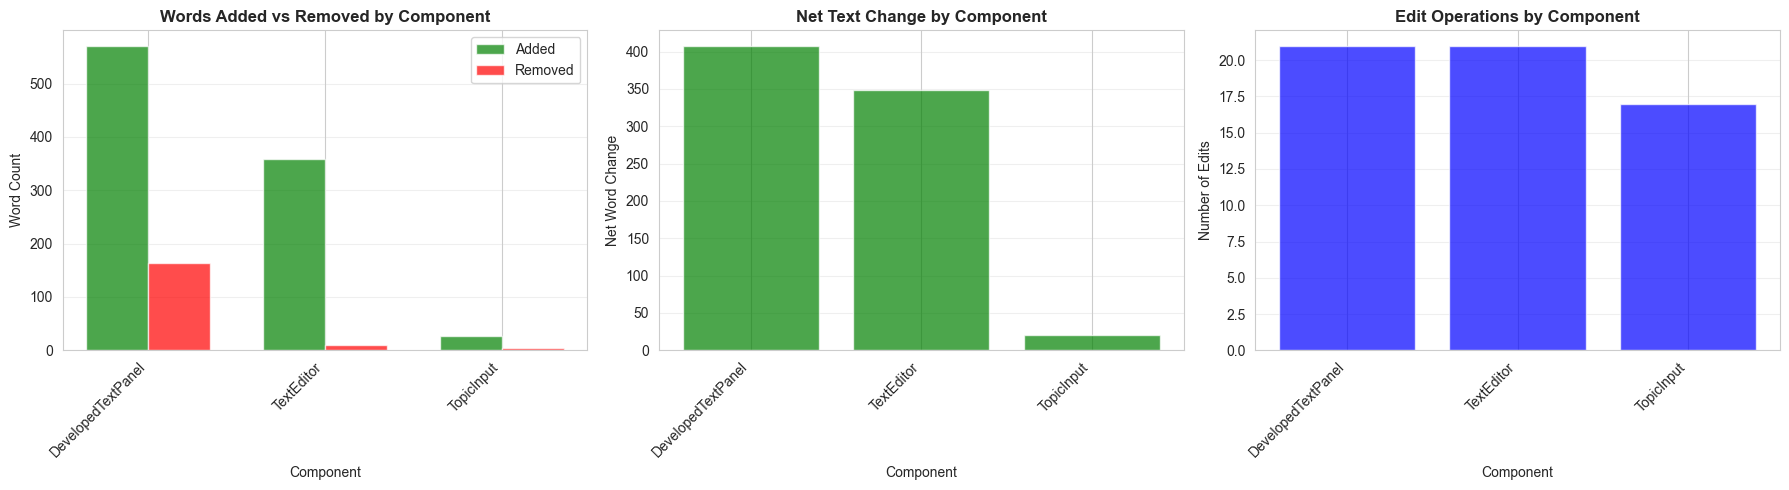

In [64]:
# Visualize revision activity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Words added vs removed by component
x = np.arange(len(revision_summary))
width = 0.35

axes[0].bar(x - width/2, revision_summary['words_added'], width, label='Added', color='green', alpha=0.7)
axes[0].bar(x + width/2, revision_summary['words_removed'], width, label='Removed', color='red', alpha=0.7)
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Word Count')
axes[0].set_title('Words Added vs Removed by Component', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(revision_summary['component'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Net change by component
colors = ['green' if x > 0 else 'red' for x in revision_summary['net_change']]
axes[1].bar(revision_summary['component'], revision_summary['net_change'], color=colors, alpha=0.7)
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Net Word Change')
axes[1].set_title('Net Text Change by Component', fontweight='bold')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].tick_params(axis='x', rotation=45)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Edit count by component
axes[2].bar(revision_summary['component'], revision_summary['edit_count'], color='blue', alpha=0.7)
axes[2].set_xlabel('Component')
axes[2].set_ylabel('Number of Edits')
axes[2].set_title('Edit Operations by Component', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)
plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [65]:
# Break down by human vs AI edits
print("=== Edits by Source (Human vs AI) ===")
print(text_diff_logs['by'].value_counts())

# Calculate revision activity by component AND source
revision_by_source = text_diff_logs.groupby(['location', 'by']).agg({
    'addedWords': 'sum',
    'removedWords': 'sum',
    'ts': 'count'
}).reset_index()

revision_by_source.columns = ['component', 'source', 'words_added', 'words_removed', 'edit_count']
revision_by_source['net_change'] = revision_by_source['words_added'] - revision_by_source['words_removed']

print("\n=== Text Revision Activity by Component and Source ===")
print(revision_by_source.to_string(index=False))

# Summary by source
print("\n=== Summary by Source ===")
source_summary = revision_by_source.groupby('source').agg({
    'words_added': 'sum',
    'words_removed': 'sum',
    'edit_count': 'sum',
    'net_change': 'sum'
}).reset_index()
print(source_summary.to_string(index=False))

=== Edits by Source (Human vs AI) ===
by
human    43
ai       16
Name: count, dtype: int64

=== Text Revision Activity by Component and Source ===
         component source  words_added  words_removed  edit_count  net_change
DevelopedTextPanel     ai        543.0          148.0          10       395.0
DevelopedTextPanel  human         28.0           15.0          11        13.0
        TextEditor     ai         93.0            0.0           6        93.0
        TextEditor  human        266.0           10.0          15       256.0
        TopicInput  human         26.0            5.0          17        21.0

=== Summary by Source ===
source  words_added  words_removed  edit_count  net_change
    ai        636.0          148.0          16       488.0
 human        320.0           30.0          43       290.0


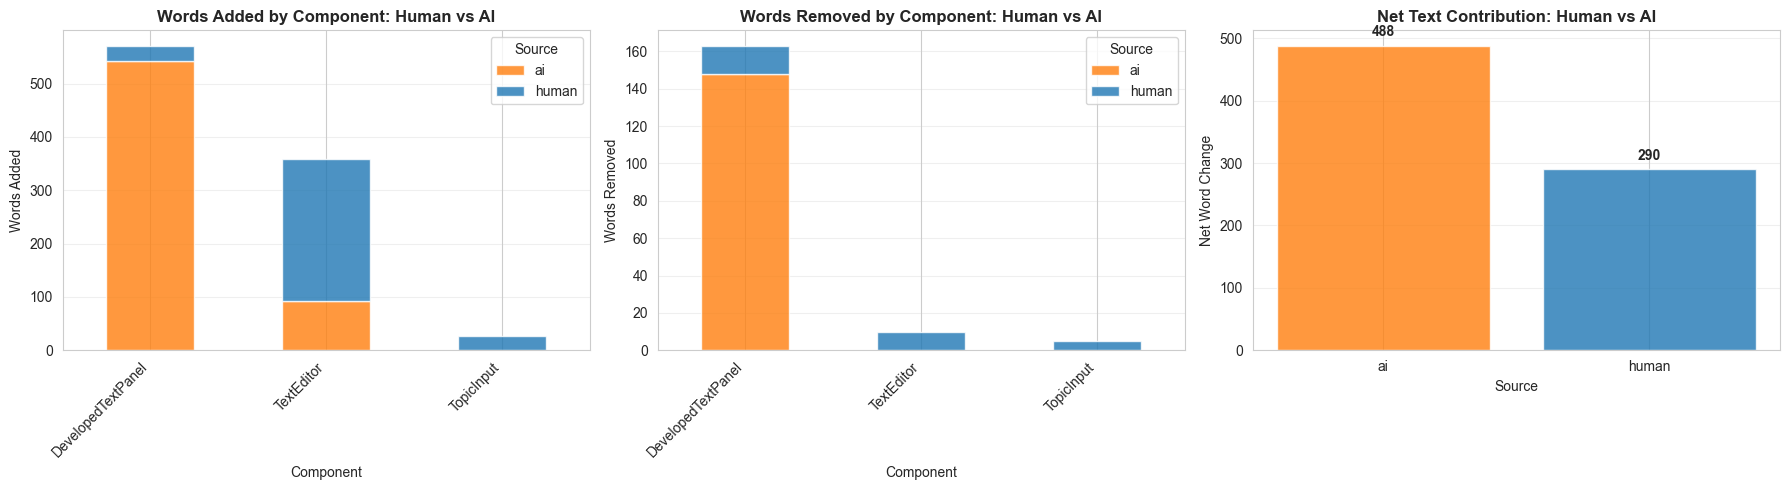


=== Key Insights ===
• AI contributed 488 net words
• Human added 290 net words
• AI did most text generation, human focused on editing/refinement


In [66]:
# Visualize human vs AI contribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Stacked bar chart of words added by component and source
pivot_added = revision_by_source.pivot(index='component', columns='source', values='words_added').fillna(0)
pivot_added.plot(kind='bar', stacked=True, ax=axes[0], color=['#ff7f0e', '#1f77b4'], alpha=0.8)
axes[0].set_title('Words Added by Component: Human vs AI', fontweight='bold')
axes[0].set_xlabel('Component')
axes[0].set_ylabel('Words Added')
axes[0].legend(title='Source')
axes[0].tick_params(axis='x', rotation=45)
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Stacked bar chart of words removed by component and source
pivot_removed = revision_by_source.pivot(index='component', columns='source', values='words_removed').fillna(0)
pivot_removed.plot(kind='bar', stacked=True, ax=axes[1], color=['#ff7f0e', '#1f77b4'], alpha=0.8)
axes[1].set_title('Words Removed by Component: Human vs AI', fontweight='bold')
axes[1].set_xlabel('Component')
axes[1].set_ylabel('Words Removed')
axes[1].legend(title='Source')
axes[1].tick_params(axis='x', rotation=45)
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Plot 3: Net contribution by source
axes[2].bar(source_summary['source'], source_summary['net_change'], 
            color=['#ff7f0e', '#1f77b4'], alpha=0.8)
axes[2].set_title('Net Text Contribution: Human vs AI', fontweight='bold')
axes[2].set_xlabel('Source')
axes[2].set_ylabel('Net Word Change')
axes[2].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[2].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (source, net) in enumerate(zip(source_summary['source'], source_summary['net_change'])):
    axes[2].text(i, net + 10, f'{net:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n=== Key Insights ===")
# Check if AI contributions exist
ai_data = source_summary[source_summary['source']=='ai']
if len(ai_data) > 0:
    ai_net = ai_data['net_change'].values[0]
    print(f"• AI contributed {ai_net:.0f} net words")
else:
    print(f"• AI contributed 0 net words (no AI edits in this session)")

# Check if human contributions exist
human_data = source_summary[source_summary['source']=='human']
if len(human_data) > 0:
    human_net = human_data['net_change'].values[0]
    if human_net < 0:
        print(f"• Human removed {abs(human_net):.0f} net words")
    else:
        print(f"• Human added {human_net:.0f} net words")
else:
    print(f"• Human contributed 0 net words (no human edits in this session)")

# Overall interpretation
if len(ai_data) > 0 and len(human_data) > 0:
    print(f"• AI did most text generation, human focused on editing/refinement")
elif len(ai_data) > 0:
    print(f"• Only AI contributions recorded in this session")
elif len(human_data) > 0:
    print(f"• Only human contributions recorded in this session")


## 12. Block reordering analysis

Analyze the number of times the user reordered blocks in the TextEditor component in "block" mode

In [67]:
# Filter BLOCK_REORDER logs
block_reorder_logs = aoi_df[aoi_df['type'] == 'BLOCK_REORDER'].copy()

print(f"Found {len(block_reorder_logs)} BLOCK_REORDER logs")

if len(block_reorder_logs) > 0:
    print(f"\nWriting modes: {block_reorder_logs['writingMode'].value_counts().to_dict()}")
    
    # Look at the structure of one example
    print("\n=== Example BLOCK_REORDER log ===")
    example = block_reorder_logs.iloc[0].to_dict()
    print(json.dumps(example, indent=2, default=str))
else:
    print("\nNo BLOCK_REORDER logs found in this session.")
    print("The user did not reorder any blocks during this writing session.")

Found 10 BLOCK_REORDER logs

Writing modes: {'block': 10}

=== Example BLOCK_REORDER log ===
{
  "ts": 1770261160341,
  "sessionId": "session-1770260877920",
  "type": "BLOCK_REORDER",
  "reason": NaN,
  "writingMode": "block",
  "window": NaN,
  "areas": NaN,
  "location": "TextEditor",
  "by": NaN,
  "addedWords": NaN,
  "removedWords": NaN,
  "targetId": NaN,
  "blockId": NaN,
  "indexId": NaN,
  "editType": NaN,
  "moveType": "demote-to-child",
  "draggedBlockId": 2.0,
  "targetBlockId": 1.0,
  "oldParentId": NaN,
  "newParentId": 1.0
}


In [68]:
# Analyze block reordering events in detail
if len(block_reorder_logs) > 0:
    print("=== Block Reordering Summary ===")
    print(f"Total reordering events: {len(block_reorder_logs)}")
    print(f"Location: {block_reorder_logs['location'].unique().tolist()}")
    print(f"Writing mode: {block_reorder_logs['writingMode'].unique().tolist()}")
    
    # Analyze reorder types
    print(f"\n=== Reorder Types ===")
    move_types = block_reorder_logs['moveType'].value_counts()
    print(move_types)
    
    # Detailed breakdown of each reorder event
    print(f"\n=== Detailed Reorder Events ===")
    for idx, row in block_reorder_logs.iterrows():
        timestamp_sec = row['ts'] / 1000
        print(f"\nEvent {idx + 1} at {timestamp_sec:.2f}s:")
        print(f"  Move type: {row['moveType']}")
        print(f"  Dragged block ID: {int(row['draggedBlockId']) if pd.notna(row['draggedBlockId']) else 'N/A'}")
        print(f"  Target block ID: {int(row['targetBlockId']) if pd.notna(row['targetBlockId']) else 'N/A'}")
        if pd.notna(row['oldParentId']):
            print(f"  Old parent ID: {int(row['oldParentId'])}")
        if pd.notna(row['newParentId']):
            print(f"  New parent ID: {int(row['newParentId'])}")
        
    # Calculate time between reordering events
    if len(block_reorder_logs) > 1:
        print(f"\n=== Timing Analysis ===")
        timestamps = sorted(block_reorder_logs['ts'].values)
        for i in range(len(timestamps) - 1):
            time_diff = (timestamps[i+1] - timestamps[i]) / 1000
            print(f"Time between event {i+1} and {i+2}: {time_diff:.1f} seconds")
else:
    print("No reordering events to analyze.")

=== Block Reordering Summary ===
Total reordering events: 10
Location: ['TextEditor']
Writing mode: ['block']

=== Reorder Types ===
moveType
demote-to-child      5
reorder-top-level    2
child-reassign       2
reorder-children     1
Name: count, dtype: int64

=== Detailed Reorder Events ===

Event 390 at 1770261160.34s:
  Move type: demote-to-child
  Dragged block ID: 2
  Target block ID: 1
  New parent ID: 1

Event 458 at 1770261180.15s:
  Move type: demote-to-child
  Dragged block ID: 5
  Target block ID: 3
  New parent ID: 3

Event 492 at 1770261189.94s:
  Move type: reorder-top-level
  Dragged block ID: 6
  Target block ID: 8

Event 575 at 1770261202.37s:
  Move type: child-reassign
  Dragged block ID: 5
  Target block ID: 6
  Old parent ID: 3
  New parent ID: 6

Event 590 at 1770261207.00s:
  Move type: child-reassign
  Dragged block ID: 5
  Target block ID: 3
  Old parent ID: 6
  New parent ID: 3

Event 1400 at 1770261591.56s:
  Move type: reorder-top-level
  Dragged block ID: 1

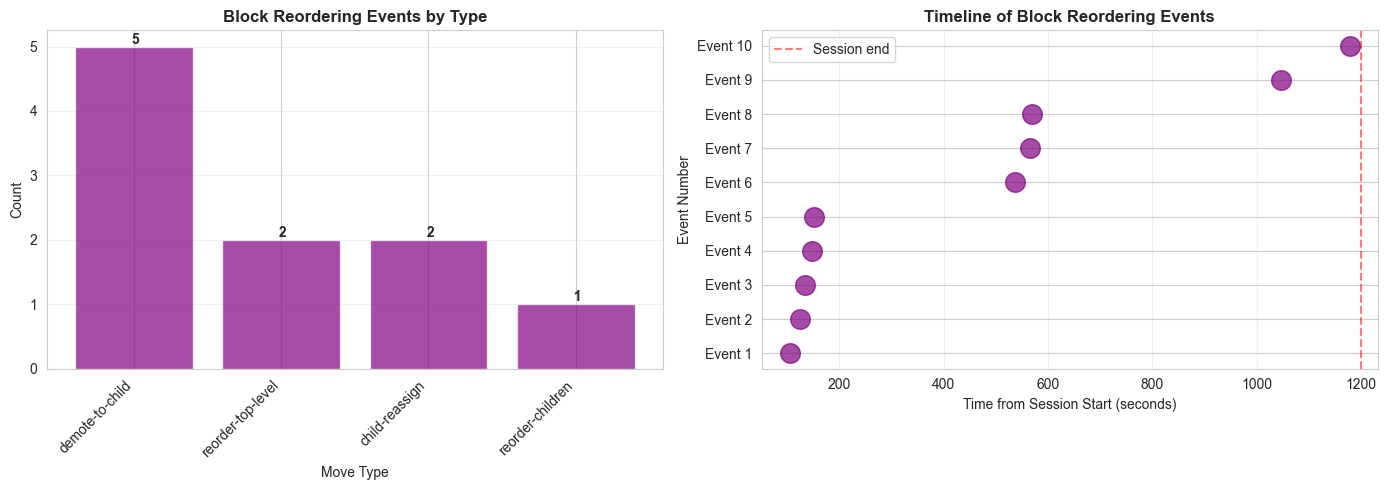


=== Key Insights ===
• User reordered blocks 10 times during the session
• All reorderings were 'demote-to-child' operations
• Reordering occurred at 105.6s into the session
• Both reordering events happened within 1072.0s of each other


In [69]:
# Visualize block reordering activity
if len(block_reorder_logs) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Reorder types distribution
    move_type_counts = block_reorder_logs['moveType'].value_counts()
    axes[0].bar(range(len(move_type_counts)), move_type_counts.values, color='purple', alpha=0.7)
    axes[0].set_xticks(range(len(move_type_counts)))
    axes[0].set_xticklabels(move_type_counts.index, rotation=45, ha='right')
    axes[0].set_xlabel('Move Type')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Block Reordering Events by Type', fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for i, v in enumerate(move_type_counts.values):
        axes[0].text(i, v, f' {int(v)}', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Timeline of reordering events
    block_reorder_logs['timestamp_sec'] = block_reorder_logs['ts'] / 1000
    block_reorder_logs_sorted = block_reorder_logs.sort_values('timestamp_sec')
    
    # Relative to start of session
    start_time = gaze_df['timestamp'].min()
    block_reorder_logs_sorted['relative_time'] = block_reorder_logs_sorted['timestamp_sec'] - start_time
    
    axes[1].scatter(block_reorder_logs_sorted['relative_time'], 
                    range(len(block_reorder_logs_sorted)), 
                    s=200, color='purple', alpha=0.7, marker='o')
    axes[1].set_xlabel('Time from Session Start (seconds)')
    axes[1].set_ylabel('Event Number')
    axes[1].set_title('Timeline of Block Reordering Events', fontweight='bold')
    axes[1].set_yticks(range(len(block_reorder_logs_sorted)))
    axes[1].set_yticklabels([f'Event {i+1}' for i in range(len(block_reorder_logs_sorted))])
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add vertical line for total session duration
    total_duration = gaze_df['timestamp'].max() - start_time
    axes[1].axvline(x=total_duration, color='red', linestyle='--', alpha=0.5, label='Session end')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== Key Insights ===")
    print(f"• User reordered blocks {len(block_reorder_logs)} times during the session")
    print(f"• All reorderings were '{block_reorder_logs['moveType'].mode()[0]}' operations")
    print(f"• Reordering occurred at {block_reorder_logs_sorted['relative_time'].min():.1f}s into the session")
    print(f"• Both reordering events happened within {(block_reorder_logs_sorted['relative_time'].max() - block_reorder_logs_sorted['relative_time'].min()):.1f}s of each other")
else:
    print("No reordering events to visualize.")

## 13. Attention Flow Analysis: Fixation Transitions

Analyze how the user's attention flowed throughout the writing session by tracking transitions between AOI components during fixations.

In [70]:
# Sort fixations by time and create a transition sequence
fixation_sequence = fixations_with_aoi.sort_values('onset').copy()

# Filter to only in-AOI fixations (exclude outside_aoi) for cleaner analysis
fixation_sequence_filtered = fixation_sequence[fixation_sequence['aoi_component'] != 'outside_aoi'].copy()

print(f"Total fixations within AOI: {len(fixation_sequence_filtered)}")
print(f"Unique components: {fixation_sequence_filtered['aoi_component'].unique().tolist()}")

Total fixations within AOI: 1228
Unique components: ['TopicInput', 'TextEditor', 'WritingBlock', 'DevelopedTextPanel']


In [71]:
# Build transition matrix - track fixation transitions from one component to another
from collections import defaultdict

# Get the sequence of components (excluding outside_aoi)
component_seq = fixation_sequence_filtered['aoi_component'].values

# Count transitions
transitions = defaultdict(lambda: defaultdict(int))
transition_list = []

for i in range(len(component_seq) - 1):
    from_component = component_seq[i]
    to_component = component_seq[i + 1]
    
    if from_component != to_component:  # Only count actual transitions (not staying in same area)
        transitions[from_component][to_component] += 1
        transition_list.append({'from': from_component, 'to': to_component})

# Create transition matrix DataFrame for visualization
transition_df = pd.DataFrame(transition_list)

print(f"=== Fixation Transitions Analysis ===")
print(f"Total transitions: {len(transition_list)}")
print(f"Unique component pairs: {len(transition_df.groupby(['from', 'to']))}")

# Build a summary table
transition_matrix = transition_df.groupby(['from', 'to']).size().unstack(fill_value=0)
print(f"\n=== Transition Matrix (from → to) ===")
print(transition_matrix)

# Calculate transition probabilities from each component
print(f"\n=== Transition Probabilities ===")
for component in transition_matrix.index:
    total = transition_matrix.loc[component].sum()
    print(f"\nFrom {component}:")
    for to_comp in transition_matrix.columns:
        count = transition_matrix.loc[component, to_comp]
        if count > 0:
            prob = count / total * 100
            print(f"  → {to_comp}: {count} times ({prob:.1f}%)")

=== Fixation Transitions Analysis ===
Total transitions: 86
Unique component pairs: 10

=== Transition Matrix (from → to) ===
to                  DevelopedTextPanel  TextEditor  TopicInput  WritingBlock
from                                                                        
DevelopedTextPanel                   0          19           0             4
TextEditor                          21           0           1            17
TopicInput                           0           1           0             1
WritingBlock                         2          19           1             0

=== Transition Probabilities ===

From DevelopedTextPanel:
  → TextEditor: 19 times (82.6%)
  → WritingBlock: 4 times (17.4%)

From TextEditor:
  → DevelopedTextPanel: 21 times (53.8%)
  → TopicInput: 1 times (2.6%)
  → WritingBlock: 17 times (43.6%)

From TopicInput:
  → TextEditor: 1 times (50.0%)
  → WritingBlock: 1 times (50.0%)

From WritingBlock:
  → DevelopedTextPanel: 2 times (9.1%)
  → TextEditor: 1

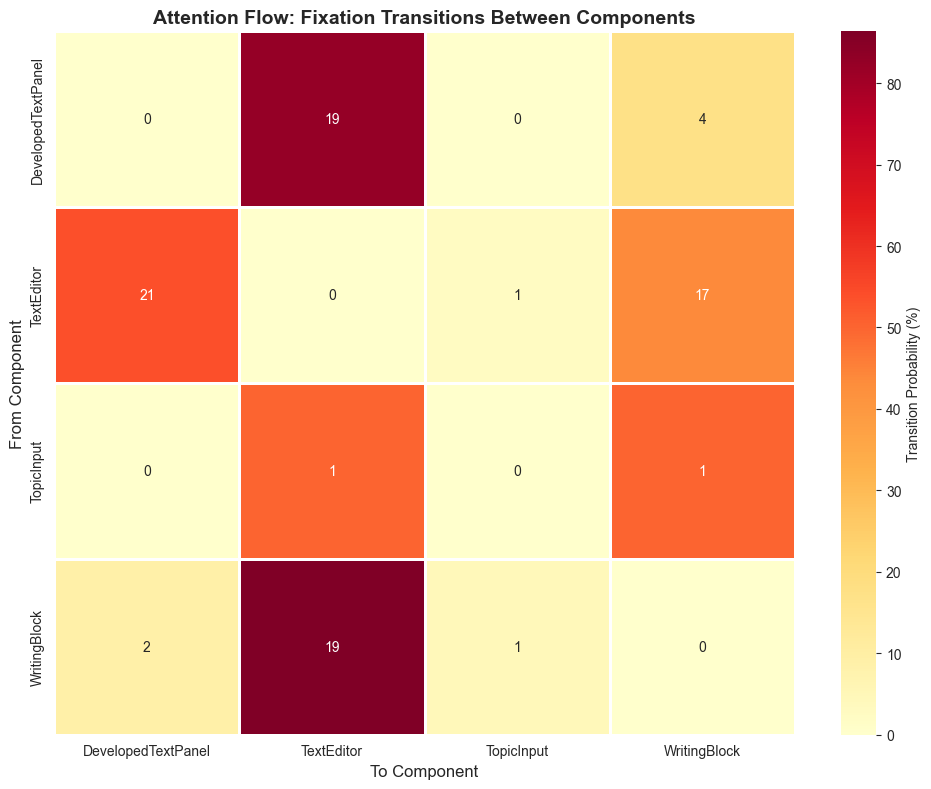


=== Interpretation ===
• Numbers show transition counts (actual frequency)
• Color intensity shows transition probability (%)
• Darker = more likely transitions
• Diagonal values (if any) would indicate staying in same component


In [72]:
# Visualize transition matrix as heatmap
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))

# Create normalized transition matrix (probabilities)
transition_prob = transition_matrix.div(transition_matrix.sum(axis=1), axis=0) * 100

sns.heatmap(transition_prob, annot=transition_matrix.values, fmt='d', cmap='YlOrRd', 
            cbar_kws={'label': 'Transition Probability (%)'}, ax=ax, linewidths=1)
ax.set_title('Attention Flow: Fixation Transitions Between Components', fontsize=14, fontweight='bold')
ax.set_xlabel('To Component', fontsize=12)
ax.set_ylabel('From Component', fontsize=12)
plt.tight_layout()
plt.show()

print("\n=== Interpretation ===")
print("• Numbers show transition counts (actual frequency)")
print("• Color intensity shows transition probability (%)") 
print("• Darker = more likely transitions")
print("• Diagonal values (if any) would indicate staying in same component")

In [73]:
# Calculate flow statistics - which components are "hubs" in attention
print("=== Attention Flow Statistics ===\n")

# In-degree (how many fixations come TO this component)
in_degree = transition_df.groupby('to').size().sort_values(ascending=False)
print("In-Degree (popularity - how often fixations move TO this component):")
print(in_degree)

# Out-degree (how many fixations leave FROM this component)
out_degree = transition_df.groupby('from').size().sort_values(ascending=False)
print("\nOut-Degree (activity - how often fixations leave FROM this component):")
print(out_degree)

# Net flow (out minus in)
all_components = set(in_degree.index) | set(out_degree.index)
net_flow = {}
for comp in all_components:
    net_flow[comp] = out_degree.get(comp, 0) - in_degree.get(comp, 0)

net_flow_df = pd.DataFrame(list(net_flow.items()), columns=['Component', 'Net Flow'])
net_flow_df = net_flow_df.sort_values('Net Flow', ascending=False)

print("\nNet Flow (positive = initiates transitions, negative = attracts attention):")
print(net_flow_df.to_string(index=False))

=== Attention Flow Statistics ===

In-Degree (popularity - how often fixations move TO this component):
to
TextEditor            39
DevelopedTextPanel    23
WritingBlock          22
TopicInput             2
dtype: int64

Out-Degree (activity - how often fixations leave FROM this component):
from
TextEditor            39
DevelopedTextPanel    23
WritingBlock          22
TopicInput             2
dtype: int64

Net Flow (positive = initiates transitions, negative = attracts attention):
         Component  Net Flow
DevelopedTextPanel         0
        TextEditor         0
        TopicInput         0
      WritingBlock         0


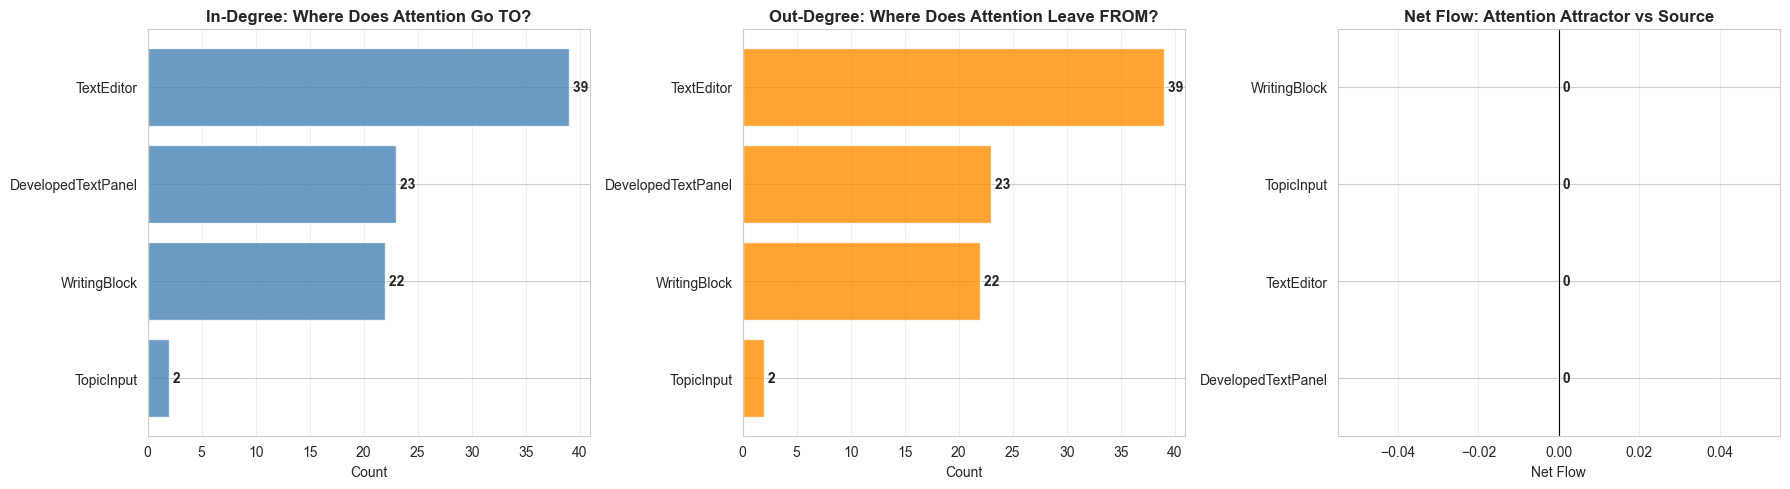

In [74]:
# Visualize the flow statistics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: In-degree
in_degree_sorted = in_degree.sort_values(ascending=True)
axes[0].barh(in_degree_sorted.index, in_degree_sorted.values, color='steelblue', alpha=0.8)
axes[0].set_xlabel('Count')
axes[0].set_title('In-Degree: Where Does Attention Go TO?', fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, v in enumerate(in_degree_sorted.values):
    axes[0].text(v, i, f' {int(v)}', va='center', fontweight='bold')

# Plot 2: Out-degree
out_degree_sorted = out_degree.sort_values(ascending=True)
axes[1].barh(out_degree_sorted.index, out_degree_sorted.values, color='darkorange', alpha=0.8)
axes[1].set_xlabel('Count')
axes[1].set_title('Out-Degree: Where Does Attention Leave FROM?', fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)
for i, v in enumerate(out_degree_sorted.values):
    axes[1].text(v, i, f' {int(v)}', va='center', fontweight='bold')

# Plot 3: Net flow
net_flow_sorted = net_flow_df.sort_values('Net Flow')
colors = ['#d62728' if x < 0 else '#2ca02c' for x in net_flow_sorted['Net Flow']]
axes[2].barh(net_flow_sorted['Component'], net_flow_sorted['Net Flow'], color=colors, alpha=0.8)
axes[2].set_xlabel('Net Flow')
axes[2].set_title('Net Flow: Attention Attractor vs Source', fontweight='bold')
axes[2].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
axes[2].grid(axis='x', alpha=0.3)
for i, v in enumerate(net_flow_sorted['Net Flow']):
    axes[2].text(v, i, f' {int(v)}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [75]:
# Analyze temporal flow - how does attention evolve over time?
# Group fixations into time windows to see if attention patterns change

fixation_sequence_filtered['time_window'] = pd.cut(
    fixation_sequence_filtered['onset'], 
    bins=5, 
    labels=['Early', 'Mid-Early', 'Middle', 'Mid-Late', 'Late']
)

print("=== Attention Focus by Writing Stage ===\n")

for window in ['Early', 'Mid-Early', 'Middle', 'Mid-Late', 'Late']:
    window_data = fixation_sequence_filtered[fixation_sequence_filtered['time_window'] == window]
    if len(window_data) > 0:
        component_dist = window_data['aoi_component'].value_counts()
        total = component_dist.sum()
        print(f"{window} Stage ({len(window_data)} fixations):")
        for comp, count in component_dist.items():
            pct = count / total * 100
            print(f"  {comp}: {count} ({pct:.1f}%)")
        print()

=== Attention Focus by Writing Stage ===

Early Stage (307 fixations):
  TextEditor: 186 (60.6%)
  WritingBlock: 68 (22.1%)
  TopicInput: 53 (17.3%)

Mid-Early Stage (184 fixations):
  TextEditor: 181 (98.4%)
  WritingBlock: 3 (1.6%)

Middle Stage (247 fixations):
  TextEditor: 223 (90.3%)
  DevelopedTextPanel: 12 (4.9%)
  WritingBlock: 12 (4.9%)

Mid-Late Stage (261 fixations):
  DevelopedTextPanel: 203 (77.8%)
  TextEditor: 54 (20.7%)
  WritingBlock: 4 (1.5%)

Late Stage (229 fixations):
  TextEditor: 124 (54.1%)
  DevelopedTextPanel: 103 (45.0%)
  WritingBlock: 1 (0.4%)
  TopicInput: 1 (0.4%)



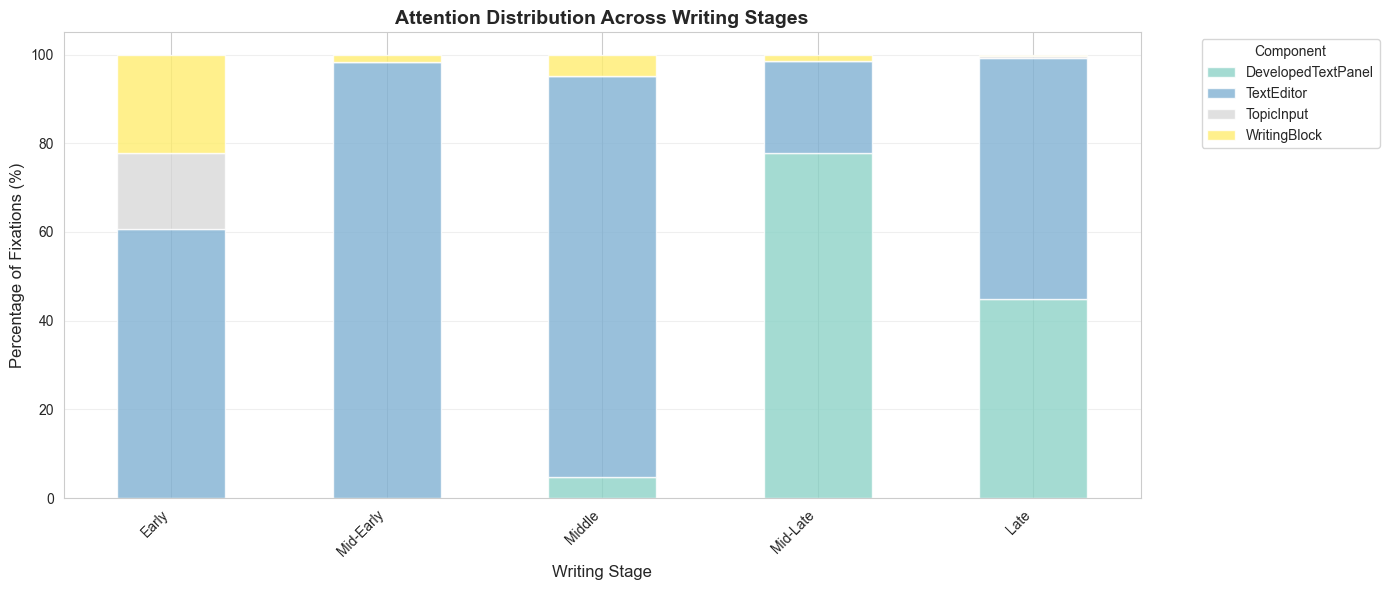


=== Key Insight ===
This shows how attention allocation changed throughout the writing session.
Notice which components became more/less important as the user progressed.


In [76]:
# Visualize how attention focus changes over time
fig, ax = plt.subplots(figsize=(14, 6))

# Create stacked bar chart of component focus by time window
stage_dist = fixation_sequence_filtered.groupby(['time_window', 'aoi_component']).size().unstack(fill_value=0)

# Reorder by stage
stage_order = ['Early', 'Mid-Early', 'Middle', 'Mid-Late', 'Late']
stage_dist = stage_dist.reindex(stage_order)

# Convert to percentage
stage_dist_pct = stage_dist.div(stage_dist.sum(axis=1), axis=0) * 100

stage_dist_pct.plot(kind='bar', stacked=True, ax=ax, colormap='Set3', alpha=0.8)
ax.set_title('Attention Distribution Across Writing Stages', fontsize=14, fontweight='bold')
ax.set_xlabel('Writing Stage', fontsize=12)
ax.set_ylabel('Percentage of Fixations (%)', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Key Insight ===")
print("This shows how attention allocation changed throughout the writing session.")
print("Notice which components became more/less important as the user progressed.")